In [1]:
import heapq
import numpy as np
from typing import Optional, List, Tuple
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from collections import namedtuple
print(np.__version__)
import random
import copy
import time

import torch
print(torch.__version__)

import torch.nn as nn
import torch.nn.functional as F

from tqdm.notebook import trange, tqdm
import wandb
from omegaconf import OmegaConf, DictConfig

# Set precision to 3 decimal places
np.set_printoptions(precision=3, suppress=True)

import pickle

from discrete_maze.maze import Maze
from discrete_maze.search_algorithm import GreedyAlgorithm
from discrete_maze.maze_dataset import MazeDataset
from discrete_maze.resnet import ResNet


2.1.3
2.5.1+cu124


In this notebook, we train the policy and value network via behavior cloning

In [ ]:
# Define the configuration using OmegaConf
cfg = OmegaConf.create({
    "name": "maze_4to50_0to0p3_500000_bc",
    "maze": {
        "width": {"min": 4, "max": 50},
        "height": {"min": 4, "max": 50},
        "cell_occupancy_prob": {"min": 0, "max": 0.3},
        "max_steps": "ShortestPath", # Use this to set the max steps to the shortest path between source and target * 2
        # "max_steps": "L1SourceTarget", # Use this to set the max steps to the L1 distance between source and target * 2
        # To set paramters to constant values, use a float
        # "width": 4,
        # "height": 4,
        # "cell_occupancy_prob": 0,
        # "max_steps": 5, 
    },
    "model": {
        "num_resBlocks": 4,
        "num_filters": 64,
        "history_length": 8, # Number of current and previous states to consider, 1 for current state only
    },
    "learn": {
        # Relevant for Expert Iteration Only
        # "num_learn_iters": 100,
        # "num_self_play_iters": 500,
        # "num_parallel_games": 250,
        # "use_curriculum": True,
        # "curriculum_success_threshold": 0.95,
        # Relevant for Behavior Cloning Only
        "train_dataset": "maze_4to50_0to0p3_500000",
        "val_dataset": "maze_4to50_0to0p3_50000",
        "val_batch_size": 128,
        # "patience": 5,
        # Relevant for both Expert Iteration and Behavior Cloning
        "num_train_epochs": 15,
        "train_batch_size": 64,
        "lr": 0.001,
        "weight_decay": 0.0001,
        "save_every": 5,
        "use_wandb": True,
        # "load_checkpoint": "maze_4to10_rtg_model_99",
    }
})

In [3]:
import torch.utils.data.dataloader


class BehaviorCloner:
    def __init__(self, model: ResNet, optimizer, cfg: DictConfig):
        self.model = model
        self.optimizer = optimizer

        self.cfg = cfg
        self.train_dataset = MazeDataset(self.cfg.learn.train_dataset, cfg=cfg)
        self.val_dataset = MazeDataset(self.cfg.learn.val_dataset, cfg=cfg)
        self.last_success_rates = []

    def train(self, train_loader, epoch):
        total_loss = 0.0

        for spatial_features, scalar_features, policy_targets, value_targets in train_loader:
            # Move data to device
            spatial_features = spatial_features.to(self.model.device)
            scalar_features = scalar_features.to(self.model.device)
            policy_targets = policy_targets.to(self.model.device)
            value_targets = value_targets.to(self.model.device)

            # Forward pass
            policy_pred, value_pred = self.model(spatial_features, scalar_features)

            value_loss = F.mse_loss(value_pred, value_targets)
            policy_loss = F.cross_entropy(policy_pred, policy_targets)
            loss = value_loss + policy_loss

            total_loss += loss.item()
            
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()

            if self.cfg.learn.use_wandb:
                # Log metrics for the current batch
                wandb.log({"batch_loss": loss.item()})
        
        avg_loss = total_loss / len(train_loader)
        if self.cfg.learn.use_wandb:
            # Log average loss for the epoch
            wandb.log({"train_epoch_loss": avg_loss, "epoch": epoch, "wall_time": time.time() - self.start_time})
    
    def validate(self, val_loader: torch.utils.data.DataLoader, epoch):
        total_loss = 0.0
        self.model.eval()  # Set model to evaluation mode

        with torch.no_grad():
            for spatial_features, scalar_features, policy_targets, value_targets in val_loader:
                # Move data to device
                spatial_features = spatial_features.to(self.model.device)
                scalar_features = scalar_features.to(self.model.device)
                policy_targets = policy_targets.to(self.model.device)
                value_targets = value_targets.to(self.model.device)

                # Forward pass
                policy_pred, value_pred = self.model(spatial_features, scalar_features)
                value_loss = F.mse_loss(value_pred, value_targets)
                policy_loss = F.cross_entropy(policy_pred, policy_targets)
                loss = value_loss + policy_loss

                total_loss += loss.item()

        avg_loss = total_loss / len(val_loader)
        if self.cfg.learn.use_wandb:
            # Log validation loss for the epoch
            wandb.log({"val_epoch_loss": avg_loss, "epoch": epoch, "wall_time": time.time() - self.start_time})

        self.model.train()  # Switch back to training mode
        return avg_loss

    def learn(self):
        if self.cfg.learn.use_wandb:
            wandb.init(project="alpha-zero-discrete-maze",
                name=self.cfg.name,
                config=OmegaConf.to_container(self.cfg, resolve=True, throw_on_missing=True),
                save_code=True)
            
            wandb.watch(self.model, log="all", log_freq=10)  # Log model gradients and parameters
        best_val_loss = float('inf')
        patience_counter = 0

        self.start_time = time.time()
        train_loader = torch.utils.data.DataLoader(
            self.train_dataset, batch_size=self.cfg.learn.train_batch_size, shuffle=True, num_workers=4
        )
        val_loader = torch.utils.data.DataLoader(
            self.val_dataset, batch_size=self.cfg.learn.val_batch_size, shuffle=False, num_workers=4
        )
            
        self.model.train()
        for epoch in trange(self.cfg.learn.num_train_epochs):
            self.train(train_loader, epoch)
            val_loss = self.validate(val_loader, epoch)

        
            # Save if iter divides save_every or if it is the last iteration
            if (epoch % self.cfg.learn.save_every == 0 and epoch != 0) or epoch == self.cfg.learn.num_train_epochs - 1:
                torch.save(self.model.state_dict(), f"checkpoints/{self.cfg.name}_model_{epoch}.pt")
                torch.save(self.optimizer.state_dict(), f"checkpoints/{self.cfg.name}_optimizer_{epoch}.pt")

                if self.cfg.learn.use_wandb:
                    # Log model checkpoint to W&B
                    wandb.save(f"{cfg.name}_model_{epoch}.pt")
                    wandb.save(f"{cfg.name}_optimizer_{epoch}.pt")
            
            # Check for improvement
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                patience_counter = 0
                # Save the best model locally
                best_model_path = f"checkpoints/{self.cfg.name}_best_model.pt"
                torch.save(self.model.state_dict(), best_model_path)

                # Log the best model as an artifact
                if self.cfg.learn.use_wandb:
                    artifact = wandb.Artifact('best_model', type='model')
                    artifact.add_file(best_model_path)
                    wandb.log_artifact(artifact, aliases=['best'])
                    # Log the epoch number
                    wandb.summary['best_epoch'] = epoch
                    wandb.summary['best_val_loss'] = best_val_loss                    
            else:
                patience_counter += 1

            # Early stopping
            if "patience" in self.cfg.learn and patience_counter >= self.cfg.learn.patience:
                print(f"Early stopping at epoch {epoch}")
                break
            
            print(f"Epoch {epoch}: Validation Loss: {val_loss}")

        if self.cfg.learn.use_wandb:
            wandb.finish()
            


In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = ResNet(cfg.model, device)
if "load_checkpoint" in cfg.learn:
    # Replace "optimizer" with "model"
    model_filename = cfg.learn.load_checkpoint.replace("optimizer", "model")
    model.load_state_dict(torch.load(f"checkpoints/{model_filename}.pt"))

optimizer = torch.optim.Adam(model.parameters(), lr=cfg.learn.lr, weight_decay=cfg.learn.weight_decay)
if "load_checkpoint" in cfg.learn:
    # Replace "model" with "optimizer"
    model_filename = cfg.learn.load_checkpoint.replace("model", "optimizer")
    optimizer.load_state_dict(torch.load(f"checkpoints/{model_filename}.pt"))


bc = BehaviorCloner(model, optimizer, cfg=cfg)

Loaded maze_4to50_0to0p3_1000 dataset with 1000 episodes, that used seed 2045782727
{'width': {'min': 4, 'max': 50}, 'height': {'min': 4, 'max': 50}, 'cell_occupancy_prob': {'min': 0, 'max': 0.3}, 'max_steps': 'ShortestPath'}


100%|██████████| 1000/1000 [00:00<00:00, 3729.50it/s]


Loaded maze_4to50_0to0p3_100 dataset with 100 episodes, that used seed 3417946397
{'width': {'min': 4, 'max': 50}, 'height': {'min': 4, 'max': 50}, 'cell_occupancy_prob': {'min': 0, 'max': 0.3}, 'max_steps': 'ShortestPath'}


100%|██████████| 100/100 [00:00<00:00, 3770.67it/s]


In [5]:
bc.learn()

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: shaoyuan (contact_placement). Use `wandb login --relogin` to force relogin


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch 0: Validation Loss: 1.1632020473480225
Epoch 1: Validation Loss: 0.6089980006217957
Epoch 2: Validation Loss: 0.37383055686950684
Epoch 3: Validation Loss: 0.6185168623924255
Epoch 4: Validation Loss: 0.5155584812164307
Epoch 5: Validation Loss: 0.3827107548713684
Epoch 6: Validation Loss: 0.5884997844696045
Epoch 7: Validation Loss: 0.6079491972923279
Epoch 8: Validation Loss: 0.6595540046691895
Epoch 9: Validation Loss: 0.4965282082557678
Epoch 10: Validation Loss: 0.4586004912853241
Epoch 11: Validation Loss: 0.6655054092407227
Epoch 12: Validation Loss: 0.6547554135322571
Epoch 13: Validation Loss: 1.282321572303772
Epoch 14: Validation Loss: 0.716168999671936


batch_loss,█▅▅▅▅▄▃▄▂▂▃▂▁▂▂▂▁▂▁▁▁▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▁▂▂▃▃▃▃▃▃▄▄▅▅▅▅▅▅▆▆▇▇▇▇▇▇██
train_epoch_loss,█▄▃▂▁▁▁▁▁▁▁▁▁▁▁
val_epoch_loss,▇▃▁▃▂▁▃▃▃▂▂▃▃█▄
wall_time,▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇███
batch_loss,0.00684
best_epoch,2
best_val_loss,0.37383
epoch,14
train_epoch_loss,0.04008
val_epoch_loss,0.71617


# Eval

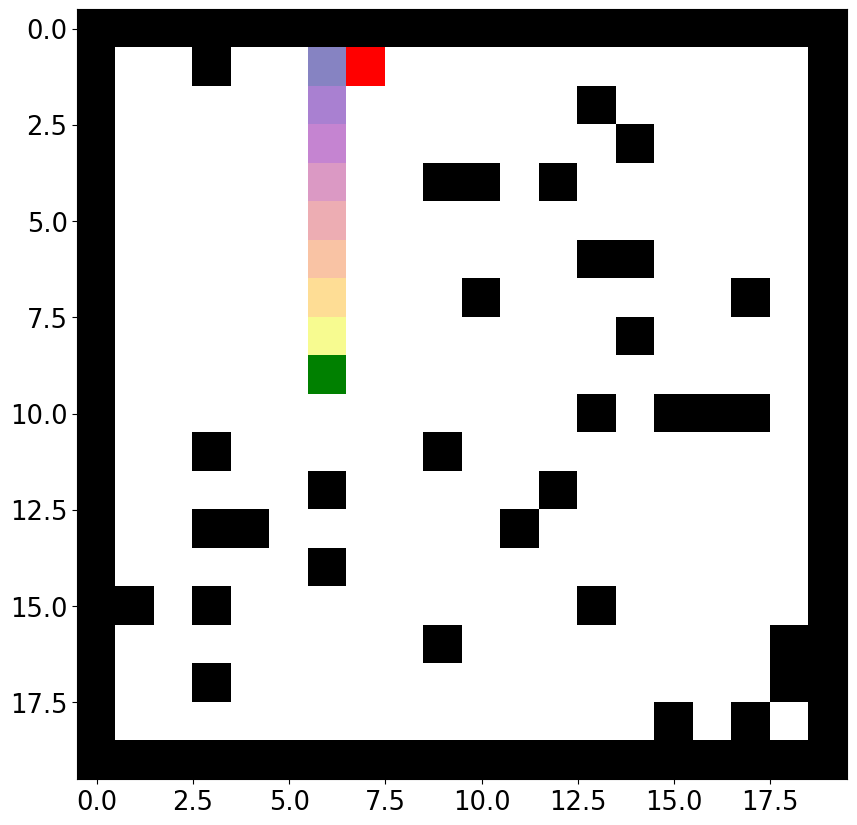

/tmp/ipykernel_1184135/3385844467.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f"checkpoints/{cfg.name}_model_{10}.pt"))


IndexError: index 20 is out of bounds for axis 0 with size 20

In [ ]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

maze = Maze(20, 20, 0.1, "ShortestPath")
maze.visualize_path()

model = ResNet(cfg.model, device)
# model.load_state_dict(torch.load(f"checkpoints/{cfg.name}_best_model.pt"))
model.load_state_dict(torch.load(f"checkpoints/{cfg.name}_model_{15}.pt"))

alg = GreedyAlgorithm(search_cfg=None, model=model)
_ =alg.play_game(maze)